In [6]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from scipy.optimize import minimize

file_path = 'MPP_CellTracks_RawValues.xlsx'
df = pd.read_excel(file_path)
dt = pd.read_excel(file_path)
df.head(5)

# The first part of the code is on finding the ideal R threshold
# Once we have filtered the data we have to see how you actually 
# parametrize a distribution. 

,x-coordinate (um),y-coordinate (um),z-coordinate (um),Time increment (3-min interval)
0,10.5564,177.909,13.8359,0
1,10.0210,175.347,15.0267,1
2,9.8610,173.524,16.4436,2
3,9.5210,169.617,17.6764,3
4,9.0260,170.557,17.0045,4


In [7]:
#Function to calculate step lengths
# First cell traj goes up to 174 time increments  
def calc_step_length(df):
    df['group_id'] = (df['Time increment (3-min interval)'] == 0).cumsum()  # Create a unique identifier for each trajectory

    df['dx'] = df.groupby('group_id')['x-coordinate (um)'].diff()
    df['dy'] = df.groupby('group_id')['y-coordinate (um)'].diff()
    df['dz'] = df.groupby('group_id')['z-coordinate (um)'].diff()

    df['step_length'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2)
    clean_step_length = df['step_length'].dropna()
    step_length = clean_step_length.to_numpy()
    return df, step_length

In [8]:
def R_filter(steps, R = 0.72):
    filtered_steps = steps[steps >= R]
    return filtered_steps

In [40]:
# Approximation to kernel density estimator for the distribution (makeshift)
def sample_steps(in_steps, n_samples, bins=1000):
    out = np.zeros(n_samples)
    probs, vals = np.histogram(in_steps, bins=bins, range=(7.2, in_steps.max()))
    probs = probs / np.sum(probs)
    for n in range(n_samples):
        bin_idx = np.nonzero(np.random.multinomial(1, probs))[0]
        low = vals[bin_idx - 1]
        high = vals[bin_idx]
        out[n] = np.random.uniform(low, high)
    return out

NameError: name 'steps' is not defined

8034
664


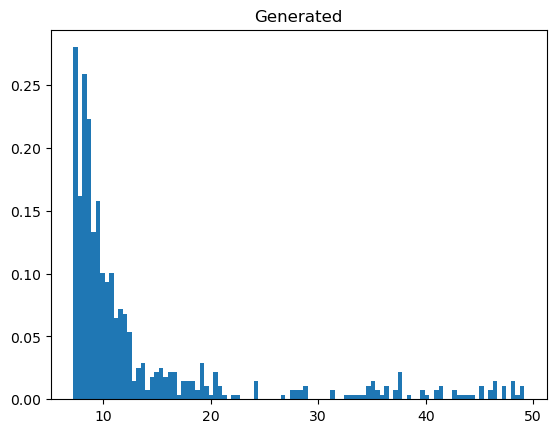

<built-in method min of numpy.ndarray object at 0x12373ddd0> 50.41326688124863 9.23889894781859
<built-in method min of numpy.ndarray object at 0x12427b3f0> 49.47855073348756 9.424282101365955


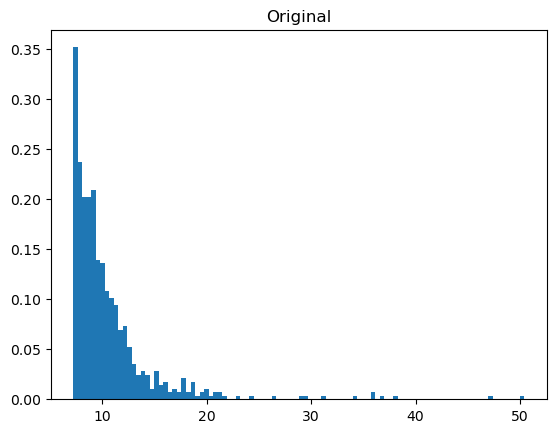

In [92]:
# Plotting and testing functions
df, steps = calc_step_length(df)
filtered_steps = R_filter(steps, 7.2)
print(len(steps))
print(len(filtered_steps))
plt.hist(sample_steps(filtered_steps, len(filtered_steps), bins=100), density=True, bins=100)
plt.title('Generated')
plt.show()
plt.hist(filtered_steps, density=True, bins=100)
plt.title('Original')
ss = sample_steps(filtered_steps, len(filtered_steps))
print(filtered_steps.min, filtered_steps.max(), np.median(filtered_steps))
print(ss.min, ss.max(), np.median(ss))


In [13]:
steps

array([2.87550027, 2.31441885, 4.11096641, ..., 5.00529744, 4.9032348 ,
       6.45576363])

In [14]:
#Time distributions
def calc_time(dt, R=7.2):
    dt['Time increment (3-min interval)'] = dt['Time increment (3-min interval)'].fillna(0)
    dt['group_id'] = (dt['Time increment (3-min interval)'] == 0).cumsum()  # Create a unique identifier for each trajectory
    
    dt = dt.dropna(subset=['step_length'])
    dt = dt[dt['step_length'] >= R]
    
    dt['dt'] = dt.groupby('group_id')['Time increment (3-min interval)'].diff()
    dt['Time increment (3-min interval)'] = dt['Time increment (3-min interval)'].fillna(0)

    clean_times = dt['dt'].dropna()
    filtered_times = clean_times.to_numpy()
    return dt, filtered_times

In [93]:
def sample_times(in_times, n_samples, bins=1000):
    out = np.zeros(n_samples)
    # removed , range=(0.72, in_times.max() since its for steps
    probs, vals = np.histogram(in_times, bins=bins)
    probs = probs / np.sum(probs)
    for n in range(n_samples):
        bin_idx = np.nonzero(np.random.multinomial(1, probs))[0]
        low = vals[bin_idx - 1]
        high = vals[bin_idx]
        out[n] = np.random.uniform(low, high)
    return out

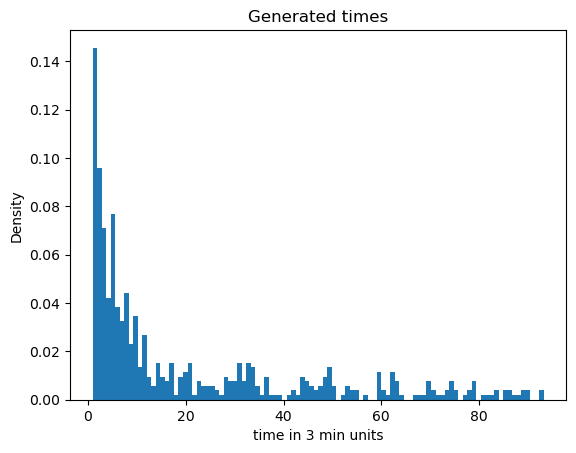

1.0 94.0 3.0
1.0074319465034254 93.27809822317711 8.197989983560877


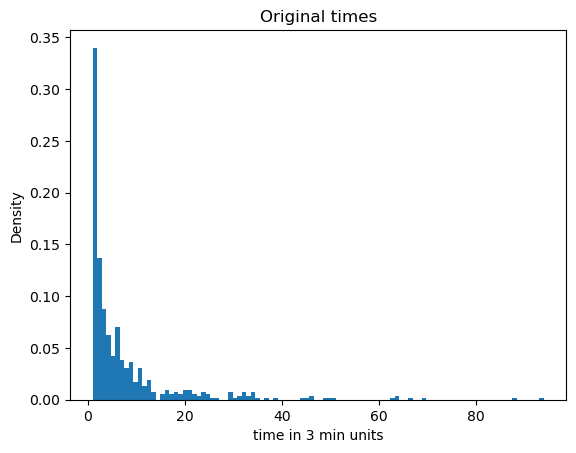

In [94]:
dt, filtered_times = calc_time(df, R=7.2)

plt.hist(sample_times(filtered_times, len(filtered_times), bins=100), density=True, bins=100)
plt.title('Generated times')
plt.xlabel('time in 3 min units')
plt.ylabel('Density')
plt.show()
plt.hist(filtered_times, density=True, bins=100)
plt.title('Original times')
plt.xlabel('time in 3 min units')
plt.ylabel('Density')

sampled_times= sample_times(filtered_times, len(filtered_times), bins=100)
print(filtered_times.min(), filtered_times.max(), np.median(filtered_times))
print(sampled_times.min(), sampled_times.max(), np.median(sampled_times))


In [ ]:
#R opti
def calculate_tamsd(step_lengths, max_lag=None):
    N = len(step_lengths)
    if max_lag is None:
        max_lag = N // 4  # Limit the maximum lag to a quarter of the total length

    tamsd = np.zeros(max_lag)
    for tau in range(1, max_lag + 1):
        sum_sq_displacements = 0
        count = 0
        for start in range(N - tau):  # Ensure not to exceed bounds
            sum_sq_displacements += (step_lengths[start + tau] - step_lengths[start]) ** 2
            count += 1
        tamsd[tau - 1] = sum_sq_displacements / count

    return tamsd


# RSSE test to optimize for R
def sse_function(R, experimental_data, experimental_tamsd):
    filt_experimental_data = R_filter(experimental_data, R)
    
    simulated_data = sample_from_steps(experimental_data, len(experimental_data))  # Assuming function to generate simulated data
    filt_simulated_data = R_filter(simulated_data, R)

    filt_experimental_tamsd = calculate_tamsd(filt_experimental_data)
    filt_simulated_tamsd = calculate_tamsd(filt_simulated_data)

    min_len = min(len(filt_experimental_tamsd), len(filt_simulated_tamsd))
    sse = np.sum((filt_experimental_tamsd[:min_len] - filt_simulated_tamsd[:min_len]) ** 2)
    return sse

def optimize_threshold(data, experimental_tamsd):
    experimental_tamsd = calculate_tamsd(experimental_data)
    result = minimize(sse_function, x0=[4], args=(data, experimental_tamsd), bounds=[(0, None)])
    if result.success:
        return result.x[0]
    else:
        raise RuntimeError("Optimization did not converge")


# are some of these pointless if i calculate them in the sse funct
experimental_data = steps[:172]  
experimental_tamsd = calculate_tamsd(experimental_data) 
optimal_R = optimize_threshold(experimental_data, experimental_tamsd)
print("Optimal R:", optimal_R)


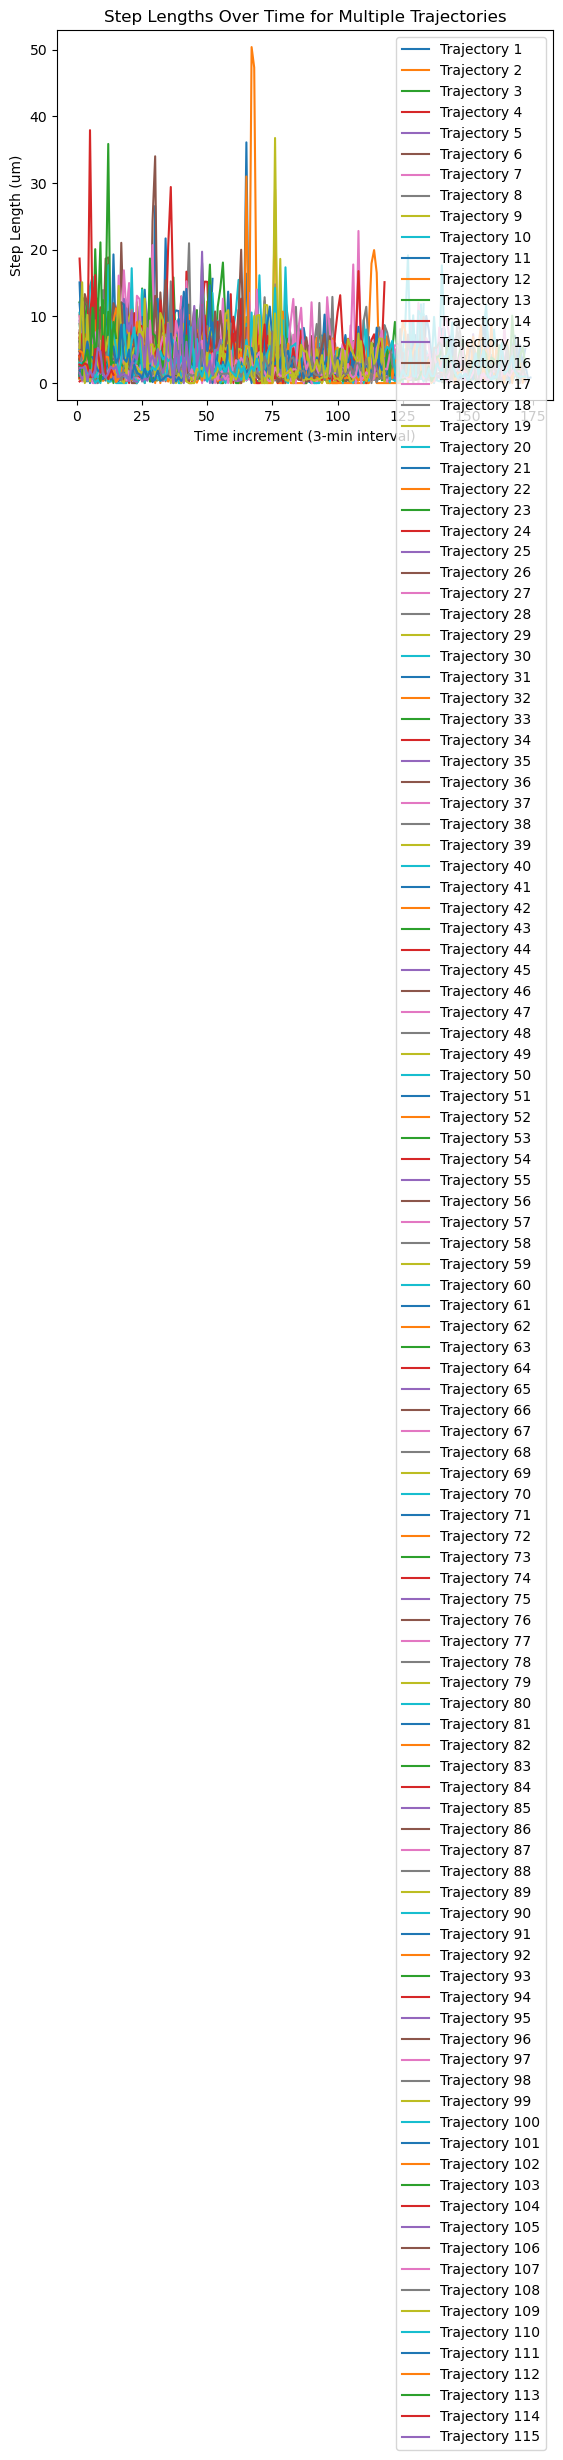

In [85]:
# This graph shows the steps size per trajectory 
# might use it to remove outliers 
for name, group in df.groupby('group_id'):
    plt.plot(group['Time increment (3-min interval)'], group['step_length'], label=f'Trajectory {name}')
    
plt.xlabel('Time increment (3-min interval)')
plt.ylabel('Step Length (um)')
plt.title('Step Lengths Over Time for Multiple Trajectories')
plt.legend()
plt.show()


In [ ]:
## Anotated version

for name, group in df.groupby('group_id'):
    plt.plot(group['Time increment (3-min interval)'], group['step_length'], label=f'Trajectory {name}')
    max_idx = group['step_length'].idxmax()
    plt.annotate(f'Traj {name}', 
                 (group.loc[max_idx, 'Time increment (3-min interval)'], group.loc[max_idx, 'step_length']),
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Time increment (3-min interval)')
plt.ylabel('Step Length (um)')
plt.title('Step Lengths Over Time for Multiple Trajectories')
plt.legend()
plt.show()